# Testing for E2 - using all spindles, training with all data
fistly define the UUID of the experiment to use

In [1]:
experimentId="a74605bf-c0bb-40f7-9b50-444123efb629"

-------------------------------------------------------

In [2]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [3]:
samplerate=200  #Should rethink this

In [4]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [5]:
#consider to include this in a function
minDuration=0.3
maxDuration=2.9
annotations=annotations[annotations.type=='spindle']
annotations=annotations[annotations.duration>minDuration]
annotations=annotations[annotations.duration<maxDuration]
annotations=annotations.reset_index(drop=True)

In [6]:
#check with EDA results (not needed)
print(1-len(annotations)/33458)

0.011297746428357902


In [7]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,spindle,E1,0001,0001,888.327805,0.640579,200,888.968384,177666,177794
1,spindle,E1,0001,0001,905.758061,0.578094,200,906.336155,181152,181267
2,spindle,E1,0001,0001,917.731574,0.847603,200,918.579177,183546,183716
3,spindle,E1,0001,0001,922.078189,0.878845,200,922.957034,184416,184591
4,spindle,E1,0001,0001,939.055445,0.757767,200,939.813212,187811,187963


In [8]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Load experiment results

In [9]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [10]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",afd523c8-e3bf-44e0-a0c7-85a7b0d747e4,0.016462
1,0001,E1,[0001],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",d90313d0-46a5-4957-b4bd-1c2e66388a31,0.023280
2,0001,E1,[0001],"[0003, 0007, 0010, 0011, 0014, 0017, 0018, 0019]","[0009, 0005, 0001]","[0002, 0006, 0012, 0013]",825f07e0-9a06-44aa-bb72-93cdd7d64ca2,0.018776
3,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0010, 0011, 0017, 0019]","[0001, 0018, 0014]","[0002, 0006, 0012, 0013]",0b4afad9-a6fb-43ae-8f49-a5d65994e109,0.016077
4,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0010, 0014, 0018, 0019]","[0009, 0011, 0017]","[0002, 0006, 0012, 0013]",bcaeb868-00a0-4038-bc73-fb5d86ea09ee,0.018950
5,0001,E1,[0001],"[0001, 0003, 0007, 0009, 0014, 0017, 0018, 0019]","[0011, 0010, 0005]","[0002, 0006, 0012, 0013]",00a66953-1236-49a2-bbdc-78c361fa15f0,0.019888
6,0001,E1,[0001],"[0001, 0005, 0007, 0010, 0011, 0014, 0017, 0019]","[0018, 0003, 0009]","[0002, 0006, 0012, 0013]",adcf962a-53df-4cb8-ae1f-7a94e2ad3e0c,0.019369
7,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0014, 0018, 0019]","[0010, 0011, 0017]","[0002, 0006, 0012, 0013]",21c95c6e-be0b-49bb-a43b-807238a1b12c,0.019076
8,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0011, 0014, 0017, 0018]","[0001, 0019, 0010]","[0002, 0006, 0012, 0013]",216f16f3-c2d8-4735-bf51-0daed207c25e,0.018514
9,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 0018]","[0017, 0019, 0014]","[0002, 0006, 0012, 0013]",09cbec08-c8af-49fb-aabd-4702bef80265,0.020993


In [11]:
#we show the difference in class inbalance for the annotation criteria considered
experimentModels[['criteriumName','spindleTimeRate']].groupby('criteriumName').describe()

spindleTimeRate                                          \
                        count      mean       std       min       25%   
criteriumName                                                           
E1                       10.0  0.019138  0.002063  0.016077  0.018579   
E2                       10.0  0.059377  0.004969  0.054294  0.056372   
union                    10.0  0.060948  0.005032  0.055834  0.058060   

                                             
                    50%       75%       max  
criteriumName                                
E1             0.019013  0.019758  0.023280  
E2             0.057708  0.060940  0.069221  
union          0.059096  0.062695  0.071169

In [12]:
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,0.5
66,petrosian,broadband,0.5
22,hjortActivity,theta,0.5
79,relativePower,beta1,0.5
29,hjortComplexity,sigma,0.5


## Hyperparameter definition
this should come from a previous evaluation notebook

In [13]:
hyperClose=0.25
hyperDuration=0.3
hyperThres=0.3
hyperBoost=30

## Testing with E2 criterium
we test the optimal points for the prediction threshold and number of boost iterations in the different validation groups

In [14]:
experimentModels=experimentModels[experimentModels.criteriumName=='E2'].reset_index(drop=True)
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678
1,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221
2,0002,E2,[0002],"[0003, 0007, 0010, 0011, 0014, 0017, 0018, 0019]","[0009, 0005, 0001]","[0002, 0006, 0012, 0013]",c556cd55-5f8b-420c-b6b2-0ca323bee5df,0.057084
3,0002,E2,[0002],"[0003, 0005, 0007, 0009, 0010, 0011, 0017, 0019]","[0001, 0018, 0014]","[0002, 0006, 0012, 0013]",b9ca9323-c013-423a-8b12-a893e0a8be97,0.054695
4,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0018, 0019]","[0009, 0011, 0017]","[0002, 0006, 0012, 0013]",e31d0f92-1914-4bb5-9156-f9101fe1307c,0.057739
5,0002,E2,[0002],"[0001, 0003, 0007, 0009, 0014, 0017, 0018, 0019]","[0011, 0010, 0005]","[0002, 0006, 0012, 0013]",6fd86953-d3aa-4c9c-8069-b22b951dce3f,0.058764
6,0002,E2,[0002],"[0001, 0005, 0007, 0010, 0011, 0014, 0017, 0019]","[0018, 0003, 0009]","[0002, 0006, 0012, 0013]",87913851-d47b-4963-b2fa-1c65d7aec5a1,0.066493
7,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0009, 0014, 0018, 0019]","[0010, 0011, 0017]","[0002, 0006, 0012, 0013]",0f0da0b8-d512-47b2-808a-c92b1d073468,0.056135
8,0002,E2,[0002],"[0003, 0005, 0007, 0009, 0011, 0014, 0017, 0018]","[0001, 0019, 0010]","[0002, 0006, 0012, 0013]",006d0918-7072-4365-953e-4b399728048d,0.054294
9,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 0018]","[0017, 0019, 0014]","[0002, 0006, 0012, 0013]",ca54dd96-c49f-4680-a78d-2aabf3059e5c,0.061666


In [15]:
#we extend the dataframe to keep the results of each testing subject separatelly
auxTesting=pd.DataFrame({
    'testSubjectId':['0002','0006','0012','0013']
})
experimentModelsExtended=pd.merge(experimentModels,auxTesting,how='cross')
experimentModelsExtended

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate,testSubjectId
0,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0002
1,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0006
2,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0012
3,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0013
4,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0002
5,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0006
6,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0012
7,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0013
8,0002,E2,[0002],"[0003, 0007, 0010, 0011, 0014, 0017, 0018, 0019]","[0009, 0005, 0001]","[0002, 0006, 0012, 0013]",c556cd55-5f8b-420c-b6b2-0ca323bee5df,0.057084,0002
9,0002,E2,[0002],"[0003, 0007, 0010, 0011, 0014, 0017, 0018, 0019]","[0009, 0005, 0001]","[0002, 0006, 0012, 0013]",c556cd55-5f8b-420c-b6b2-0ca323bee5df,0.057084,0006


In [16]:
#threshold for the metric by event
masterIoU=0.2

In [17]:
rawF1s=[]
rawPrecisions=[]
rawRecalls=[]

f1s=[]
precisions=[]
recalls=[]

eventF1s=[]
eventPrecisions=[]
eventRecalls=[]

checks=[]

for ind,row in experimentModelsExtended.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModelsExtended)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.testSubjectId
    #Define annotations criterium
    usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperBoost))
    rawLabels=probabilities>=hyperThres
    #Raw Metrics
    rawTp=np.sum(rawLabels*testLabels)
    rawFp=np.sum(rawLabels*(1-testLabels))
    rawTn=np.sum((1-rawLabels)*(1-testLabels))
    rawFn=np.sum((1-rawLabels)*testLabels)
    #Raw appends
    rawF1s.append(2*rawTp/(2*rawTp+rawFp+rawFn))
    rawPrecisions.append(rawTp/(rawTp+rawFp) )
    rawRecalls.append(rawTp/(rawTp+rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)
    #Processed metrics
    tp=np.sum(processedLabels*testLabels)
    fp=np.sum(processedLabels*(1-testLabels))
    tn=np.sum((1-processedLabels)*(1-testLabels))
    fn=np.sum((1-processedLabels)*testLabels)
    #Processed appends
    f1s.append(2*tp/(2*tp+fp+fn))
    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    eventTp,eventFp,eventFn = byEventEvaluation(gtAnnotations,processedAnnotations,thres_IoU=masterIoU)
    #consistency check
    checks.append(eventTp*2+eventFp+eventFn==len(gtAnnotations)+len(processedAnnotations))

    #calculate metrics
    eventF1s.append(2*eventTp/(2*eventTp+eventFp+eventFn))
    eventPrecisions.append(eventTp/(eventTp+eventFp))
    eventRecalls.append(eventTp/(eventTp+eventFn))

#include metrics in the dataframe
experimentModelsExtended['rawF1']=rawF1s
experimentModelsExtended['rawPrecision']=rawPrecisions
experimentModelsExtended['rawRecall']=rawRecalls

experimentModelsExtended['f1']=f1s
experimentModelsExtended['precision']=precisions
experimentModelsExtended['recall']=recalls

experimentModelsExtended['eventF1']=eventF1s
experimentModelsExtended['eventPrecision']=eventPrecisions
experimentModelsExtended['eventRecall']=eventRecalls

experimentModelsExtended['check']=checks

*************************
1 of 40
*************************
2 of 40
*************************
3 of 40
*************************
4 of 40
*************************
5 of 40
*************************
6 of 40
*************************
7 of 40
*************************
8 of 40
*************************
9 of 40
*************************
10 of 40
*************************
11 of 40
*************************
12 of 40
*************************
13 of 40
*************************
14 of 40
*************************
15 of 40
*************************
16 of 40
*************************
17 of 40
*************************
18 of 40
*************************
19 of 40
*************************
20 of 40
*************************
21 of 40
*************************
22 of 40
*************************
23 of 40
*************************
24 of 40
*************************
25 of 40
*************************
26 of 40
*************************
27 of 40
*************************
28 of 40
*************************
29 

In [18]:
np.sum(checks)==len(checks)

True

In [33]:
dumpPickle('experimentModelsExtended_E2_temp.pkl',experimentModelsExtended)

In [27]:
experimentModelsExtended.columns

Index(['criteriumId', 'criteriumName', 'labelerIdList', 'train', 'val', 'test',
       'modelId', 'spindleTimeRate', 'testSubjectId', 'rawF1', 'rawPrecision',
       'rawRecall', 'f1', 'precision', 'recall', 'eventF1', 'eventPrecision',
       'eventRecall', 'check'],
      dtype='object')

In [28]:
fig=px.scatter(experimentModelsExtended,x='rawF1',y='f1',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended['rawF1'], y=experimentModelsExtended['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [29]:
fig=px.scatter(experimentModelsExtended,x='rawF1',y='eventF1',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended['rawF1'], y=experimentModelsExtended['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [31]:
fig=px.scatter(experimentModelsExtended,x='eventF1',y='eventPrecision',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended['eventF1'], y=experimentModelsExtended['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [32]:
fig=px.scatter(experimentModelsExtended,x='eventF1',y='eventRecall',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended['eventF1'], y=experimentModelsExtended['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [50]:
experimentModelsExtended[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId').describe(percentiles=[0.5])

eventF1                                                    \
                count      mean       std       min       50%       max   
testSubjectId                                                             
0002             10.0  0.796820  0.018504  0.766936  0.792969  0.829072   
0006             10.0  0.678881  0.007812  0.663117  0.678980  0.688304   
0012             10.0  0.579064  0.029684  0.526892  0.574117  0.630865   
0013             10.0  0.565584  0.026351  0.521636  0.562369  0.612188   

              eventPrecision                                          \
                       count      mean       std       min       50%   
testSubjectId                                                          
0002                    10.0  0.683361  0.032456  0.632859  0.677101   
0006                    10.0  0.605922  0.031353  0.550643  0.604286   
0012                    10.0  0.418405  0.033153  0.363666  0.411698   
0013                    10.0  0.400022  0.026284  0.357433  0.396699   

                        eventRecall                                          \
                    max       count      mean       std       min       50%   
testSubjectId                                                                 
0002           0.742249        10.0  0.957136  0.010496  0.938896  0.956680   
0006           0.655592        10.0  0.775426  0.035002  0.720195  0.771898   
0012           0.479157        10.0  0.944732  0.010976  0.923143  0.948187   
0013           0.447368        10.0  0.967544  0.002212  0.964181  0.968567   

                         
                    max  
testSubjectId            
0002           0.973096  
0006           0.833333  
0012           0.955959  
0013           0.970029

In [51]:
experimentModelsExtended[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId',as_index=False).mean()

,testSubjectId,eventF1,eventPrecision,eventRecall
0,0002,0.796820,0.683361,0.957136
1,0006,0.678881,0.605922,0.775426
2,0012,0.579064,0.418405,0.944732
3,0013,0.565584,0.400022,0.967544


In [52]:
experimentModelsExtended[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId',as_index=False).mean().mean()

testSubjectId     5.001500e+11
eventF1           6.550872e-01
eventPrecision    5.269276e-01
eventRecall       9.112096e-01
dtype: float64

In [ ]:
experimentModelsExtended[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId',as_index=False).mean().std()

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_16920\1884038399.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.077413
eventPrecision    0.129444
eventRecall       0.091112
dtype: float64

In [195]:
auxPrecision=pd.DataFrame({
    'metric':'event precision',
    'value':experimentModelsExtended.eventPrecision,
    'event F1':experimentModelsExtended.eventF1
})

auxRecall=pd.DataFrame({
    'metric':'event recall',
    'value':experimentModelsExtended.eventRecall,
    'event F1':experimentModelsExtended.eventF1
})
visualTradeoff=pd.concat((auxPrecision,auxRecall))

In [197]:
fig=px.scatter(visualTradeoff,x='event F1',y='value',color='metric', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended['eventF1'], y=experimentModelsExtended['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

## Restrict to only N2 stage

In [20]:
experimentModelsExtended_N2=pd.merge(experimentModels,auxTesting,how='cross')
experimentModelsExtended_N2

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate,testSubjectId
0,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0002
1,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0006
2,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0012
3,0002,E2,[0002],"[0001, 0003, 0005, 0007, 0010, 0014, 0017, 0019]","[0011, 0018, 0009]","[0002, 0006, 0012, 0013]",1623c979-486c-4f45-ba54-dbbac3770588,0.057678,0013
4,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0002
5,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0006
6,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0012
7,0002,E2,[0002],"[0001, 0007, 0009, 0010, 0014, 0017, 0018, 0019]","[0011, 0003, 0005]","[0002, 0006, 0012, 0013]",f8abeec1-7d46-4573-8a01-7827b8584472,0.069221,0013
8,0002,E2,[0002],"[0003, 0007, 0010, 0011, 0014, 0017, 0018, 0019]","[0009, 0005, 0001]","[0002, 0006, 0012, 0013]",c556cd55-5f8b-420c-b6b2-0ca323bee5df,0.057084,0002
9,0002,E2,[0002],"[0003, 0007, 0010, 0011, 0014, 0017, 0018, 0019]","[0009, 0005, 0001]","[0002, 0006, 0012, 0013]",c556cd55-5f8b-420c-b6b2-0ca323bee5df,0.057084,0006


In [21]:
annotationsN2=pd.read_csv(datapath+'/MASS/annotations/spindlesFilteredN2.csv')
annotationsN2['samplerate']=samplerate
annotationsN2['subjectId']=annotationsN2.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
annotationsN2['labelerId']=annotationsN2.apply(
    lambda row: str(row.labelerId).zfill(4),axis=1)
annotationsN2['stopTime']=annotationsN2.apply(
    lambda row: row.startTime+row.duration , axis=1)
annotationsN2['startInd']=annotationsN2.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
annotationsN2['stopInd']=annotationsN2.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)

In [22]:
## load hypnograms
stagesAnnotations=pd.read_csv(datapath+"\MASS\stages\stages.csv")
stagesAnnotations['samplerate']=samplerate
stagesAnnotations['subjectId']=stagesAnnotations.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
stagesAnnotations['stopTime']=stagesAnnotations.apply(
    lambda row: row.startTime+row.duration , axis=1)
stagesAnnotations['startInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
stagesAnnotations['stopInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)
stagesAnnotations.head(5)

hypnograms={}
for ind, row in signalsMetadata.iterrows():
    subjectId=row.subjectId
    thisStages=stagesAnnotations[stagesAnnotations.subjectId==subjectId]
    excerptDimension=int(row.duration*row.samplerate)
    thisHypnogram=np.ones((excerptDimension,))*np.nan
    for ind_stg, row_stg in thisStages.iterrows():
        thisHypnogram[row_stg.startInd:row_stg.stopInd]=row_stg.value
    hypnograms[subjectId]=thisHypnogram   

In [23]:
rawF1s=[]
rawPrecisions=[]
rawRecalls=[]

f1s=[]
precisions=[]
recalls=[]

eventF1s=[]
eventPrecisions=[]
eventRecalls=[]

checks=[]

for ind,row in experimentModelsExtended_N2.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModelsExtended_N2)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.testSubjectId
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    #Define annotations criterium
    usedAnnotations=annotationsN2[annotationsN2.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperBoost))
    rawLabels=probabilities>=hyperThres

    #Apply mask ---------------------------------->
    rawLabels=rawLabels*testN2Mask
    #<---------------------------------------------

    #Raw Metrics
    rawTp=np.sum(rawLabels*testLabels)
    rawFp=np.sum(rawLabels*(1-testLabels))
    rawTn=np.sum((1-rawLabels)*(1-testLabels))
    rawFn=np.sum((1-rawLabels)*testLabels)
    #Raw appends
    rawF1s.append(2*rawTp/(2*rawTp+rawFp+rawFn))
    rawPrecisions.append(rawTp/(rawTp+rawFp) )
    rawRecalls.append(rawTp/(rawTp+rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)
    #Processed metrics
    tp=np.sum(processedLabels*testLabels)
    fp=np.sum(processedLabels*(1-testLabels))
    tn=np.sum((1-processedLabels)*(1-testLabels))
    fn=np.sum((1-processedLabels)*testLabels)
    #Processed appends
    f1s.append(2*tp/(2*tp+fp+fn))
    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    eventTp,eventFp,eventFn = byEventEvaluation(gtAnnotations,processedAnnotations,thres_IoU=masterIoU)
    #consistency check
    checks.append(eventTp*2+eventFp+eventFn==len(gtAnnotations)+len(processedAnnotations))

    #calculate metrics
    eventF1s.append(2*eventTp/(2*eventTp+eventFp+eventFn))
    eventPrecisions.append(eventTp/(eventTp+eventFp))
    eventRecalls.append(eventTp/(eventTp+eventFn))

#include metrics in the dataframe
experimentModelsExtended_N2['rawF1']=rawF1s
experimentModelsExtended_N2['rawPrecision']=rawPrecisions
experimentModelsExtended_N2['rawRecall']=rawRecalls

experimentModelsExtended_N2['f1']=f1s
experimentModelsExtended_N2['precision']=precisions
experimentModelsExtended_N2['recall']=recalls

experimentModelsExtended_N2['eventF1']=eventF1s
experimentModelsExtended_N2['eventPrecision']=eventPrecisions
experimentModelsExtended_N2['eventRecall']=eventRecalls

experimentModelsExtended_N2['check']=checks

*************************
1 of 40
*************************
2 of 40
*************************
3 of 40
*************************
4 of 40
*************************
5 of 40
*************************
6 of 40
*************************
7 of 40
*************************
8 of 40
*************************
9 of 40
*************************
10 of 40
*************************
11 of 40
*************************
12 of 40
*************************
13 of 40
*************************
14 of 40
*************************
15 of 40
*************************
16 of 40
*************************
17 of 40
*************************
18 of 40
*************************
19 of 40
*************************
20 of 40
*************************
21 of 40
*************************
22 of 40
*************************
23 of 40
*************************
24 of 40
*************************
25 of 40
*************************
26 of 40
*************************
27 of 40
*************************
28 of 40
*************************
29 

In [24]:
dumpPickle('experimentModelsExtendedN2_E2_temp.pkl',experimentModelsExtended_N2)

In [34]:
fig=px.scatter(experimentModelsExtended_N2,x='rawF1',y='f1',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended_N2['rawF1'], y=experimentModelsExtended_N2['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [35]:
fig=px.scatter(experimentModelsExtended_N2,x='rawF1',y='eventF1',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended_N2['rawF1'], y=experimentModelsExtended_N2['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [36]:
fig=px.scatter(experimentModelsExtended_N2,x='eventF1',y='eventPrecision',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended_N2['eventF1'], y=experimentModelsExtended_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [37]:
fig=px.scatter(experimentModelsExtended_N2,x='eventF1',y='eventRecall',color='testSubjectId',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModelsExtended_N2['eventF1'], y=experimentModelsExtended_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [44]:
experimentModelsExtended_N2[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId').describe(percentiles=[0.5])

eventF1                                                    \
                count      mean       std       min       50%       max   
testSubjectId                                                             
0002             10.0  0.845721  0.014716  0.823103  0.841993  0.872816   
0006             10.0  0.767230  0.006232  0.755720  0.767929  0.776620   
0012             10.0  0.718508  0.028860  0.668281  0.715402  0.768288   
0013             10.0  0.663199  0.024059  0.627442  0.657685  0.711290   

              eventPrecision                                          \
                       count      mean       std       min       50%   
testSubjectId                                                          
0002                    10.0  0.758937  0.030062  0.713538  0.752715   
0006                    10.0  0.762200  0.033589  0.704124  0.758393   
0012                    10.0  0.580777  0.041736  0.513488  0.572249   
0013                    10.0  0.504979  0.027930  0.464878  0.498677   

                        eventRecall                                          \
                    max       count      mean       std       min       50%   
testSubjectId                                                                 
0002           0.815964        10.0  0.956110  0.010692  0.938184  0.955302   
0006           0.823120        10.0  0.775000  0.034875  0.720732  0.771341   
0012           0.657619        10.0  0.945407  0.011014  0.923744  0.948873   
0013           0.561783        10.0  0.967473  0.002217  0.964103  0.968498   

                         
                    max  
testSubjectId            
0002           0.972420  
0006           0.832927  
0012           0.956672  
0013           0.969963

In [46]:
experimentModelsExtended_N2[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId',as_index=False).mean()

,testSubjectId,eventF1,eventPrecision,eventRecall
0,0002,0.845721,0.758937,0.956110
1,0006,0.767230,0.762200,0.775000
2,0012,0.718508,0.580777,0.945407
3,0013,0.663199,0.504979,0.967473


In [48]:
experimentModelsExtended_N2[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId',as_index=False).mean().mean()

testSubjectId     5.001500e+11
eventF1           7.486649e-01
eventPrecision    6.517233e-01
eventRecall       9.109975e-01
dtype: float64

In [49]:
experimentModelsExtended_N2[['testSubjectId','eventF1','eventPrecision','eventRecall']].groupby('testSubjectId',as_index=False).mean().std()

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_16920\1884038399.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.077413
eventPrecision    0.129444
eventRecall       0.091112
dtype: float64

### paint some graphs for a presentation

In [55]:
row

criteriumId                                                    0002
criteriumName                                                    E2
labelerIdList                                                [0002]
train              [0001, 0003, 0005, 0007, 0009, 0010, 0011, 0018]
val                                              [0017, 0019, 0014]
test                                       [0002, 0006, 0012, 0013]
modelId                        ca54dd96-c49f-4680-a78d-2aabf3059e5c
spindleTimeRate                                            0.061666
testSubjectId                                                  0013
Name: 39, dtype: object

In [58]:
metadata=signalsMetadata[signalsMetadata.subjectId==row.testSubjectId].iloc[0]
metadata

subjectId                        0013
file                    MASS_0013.pkl
channel                        C3-CLE
duration                      36372.0
samplerate                        200
isOriginalSamplerate            False
database                         MASS
Name: 12, dtype: object

In [61]:
timepoints=np.arange(int(metadata.duration*metadata.samplerate))/samplerate

### output

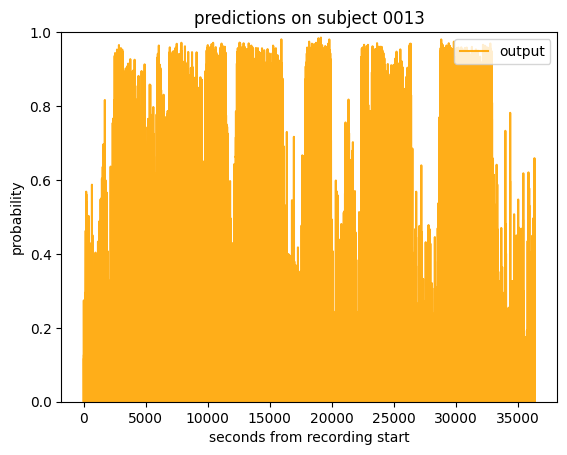

In [84]:
plt.plot(timepoints,probabilities,color='orange',alpha=0.9)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['output'],loc='upper right')
plt.show()

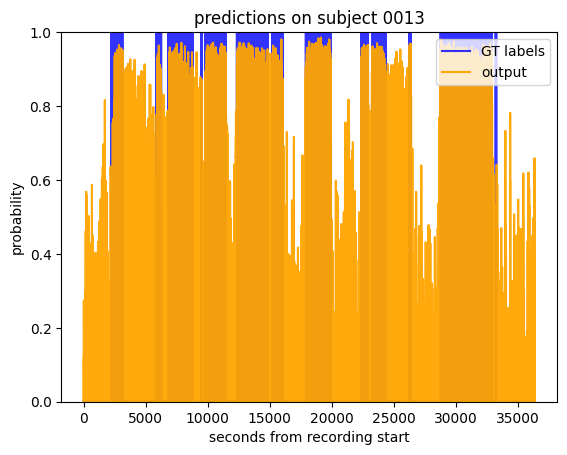

In [85]:
plt.plot(timepoints,testLabels,color='blue',alpha=0.8)
plt.plot(timepoints,probabilities,color='orange',alpha=0.95)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['GT labels','output'],loc='upper right')
plt.show()

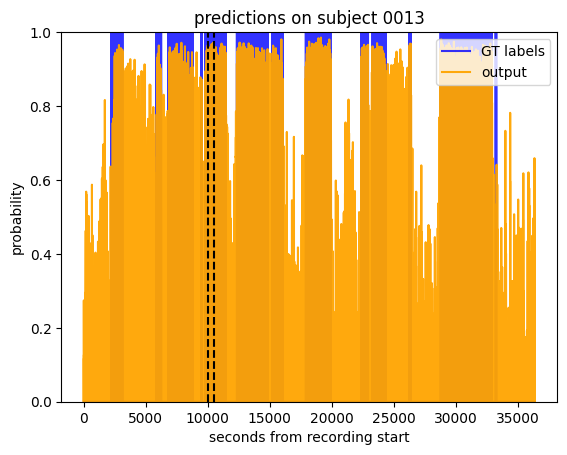

In [95]:
roiStart=10000
roiStop=10500

plt.plot(timepoints,testLabels,color='blue',alpha=0.8)
plt.plot(timepoints,probabilities,color='orange',alpha=0.95)
plt.title('predictions on subject '+metadata.subjectId)
plt.vlines((roiStart,roiStop),ymin=0,ymax=1,color='black',linestyle='dashed')
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['GT labels','output'],loc='upper right')
plt.show()

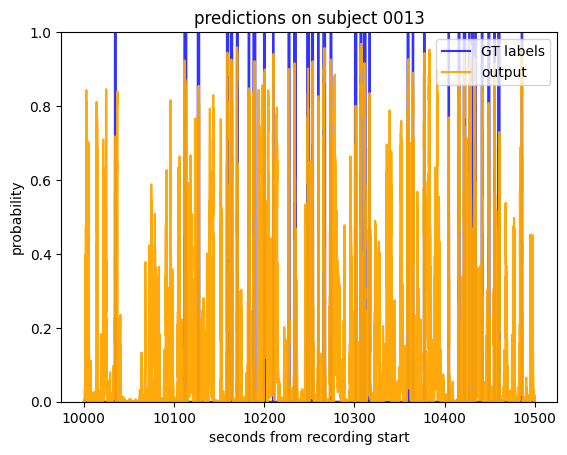

In [96]:
roi=(timepoints>roiStart)&(timepoints<roiStop)
plt.plot(timepoints[roi],testLabels[roi],color='blue',alpha=0.8)
plt.plot(timepoints[roi],probabilities[roi],color='orange',alpha=0.95)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['GT labels','output'],loc='upper right')
plt.show()

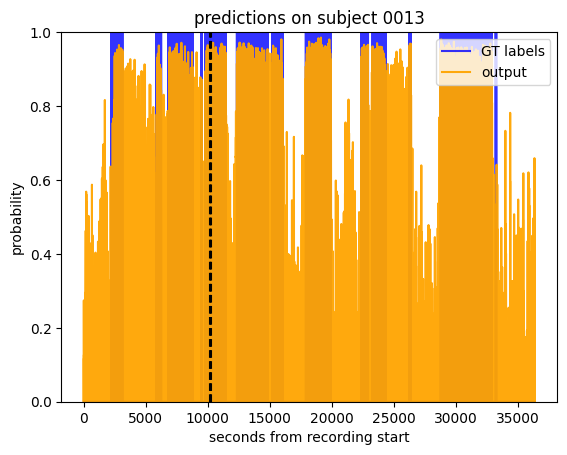

In [103]:
roiStart=10180
roiStop=10230

plt.plot(timepoints,testLabels,color='blue',alpha=0.8)
plt.plot(timepoints,probabilities,color='orange',alpha=0.95)
plt.title('predictions on subject '+metadata.subjectId)
plt.vlines((roiStart,roiStop),ymin=0,ymax=1,color='black',linestyle='dashed')
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['GT labels','output'],loc='upper right')
plt.show()

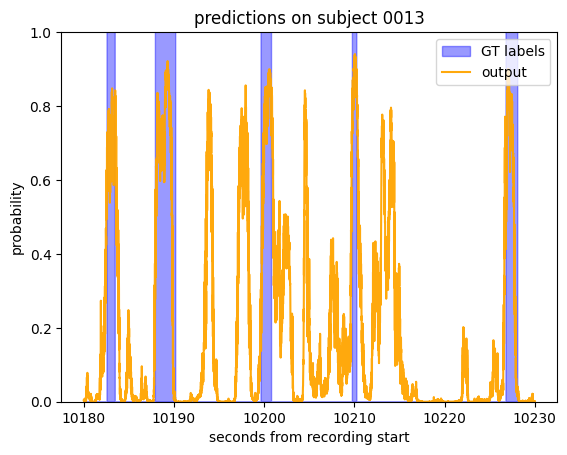

In [113]:
roi=(timepoints>roiStart)&(timepoints<roiStop)
plt.fill(timepoints[roi],testLabels[roi],color='blue',alpha=0.4)
plt.plot(timepoints[roi],probabilities[roi],color='orange',alpha=0.95)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['GT labels','output'],loc='upper right')
plt.show()

### raw

In [137]:
threshold=0.8
raw=probabilities>=threshold

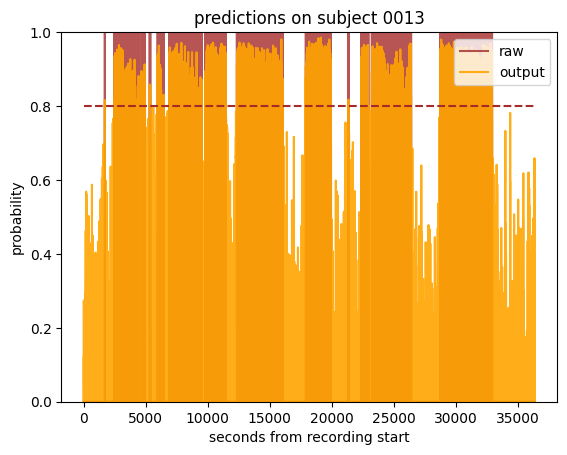

In [138]:
plt.plot(timepoints,raw,color='brown',alpha=0.8)
plt.plot(timepoints,probabilities,color='orange',alpha=0.9)
plt.hlines(y=(threshold),xmin=0,xmax=np.max(timepoints),color='brown',linestyles='dashed')
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['raw','output'],loc='upper right')
plt.show()

In [140]:
threshold=0.5
raw=probabilities>=threshold

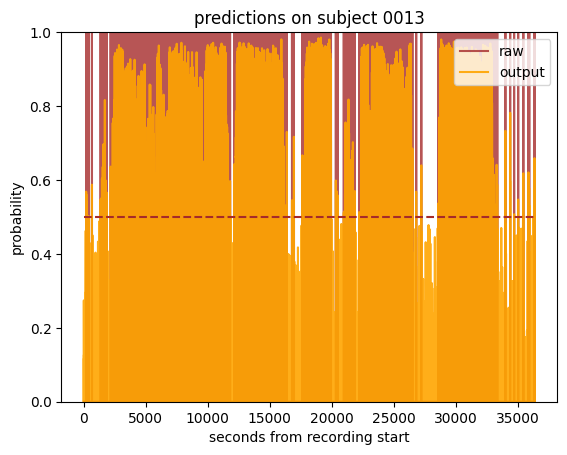

In [141]:
plt.plot(timepoints,raw,color='brown',alpha=0.8)
plt.plot(timepoints,probabilities,color='orange',alpha=0.9)
plt.hlines(y=(threshold),xmin=0,xmax=np.max(timepoints),color='brown',linestyles='dashed')
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['raw','output'],loc='upper right')
plt.show()

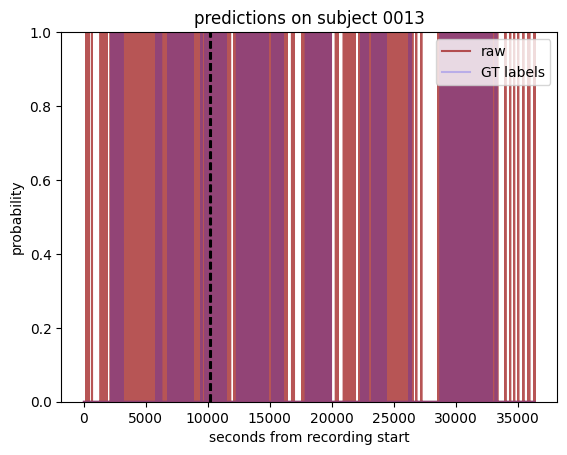

In [170]:
roiStart=10180
roiStop=10230

plt.plot(timepoints,raw,color='brown',alpha=0.8)
plt.plot(timepoints,testLabels,color='blue',alpha=0.2)
plt.title('predictions on subject '+metadata.subjectId)
plt.vlines((roiStart,roiStop),ymin=0,ymax=1,color='black',linestyle='dashed')
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['raw','GT labels'],loc='upper right')
plt.show()

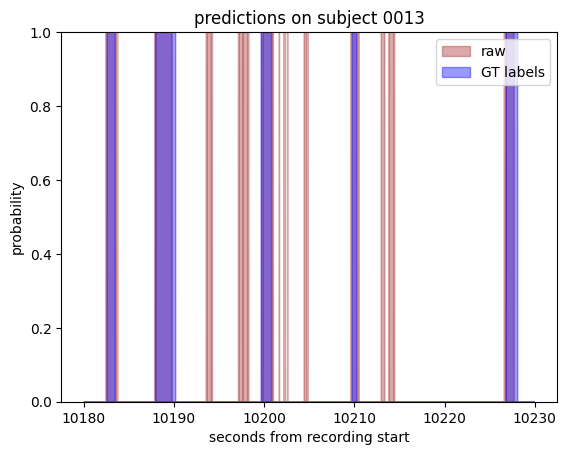

In [147]:
roi=(timepoints>roiStart)&(timepoints<roiStop)
plt.fill(timepoints[roi],raw[roi],color='brown',alpha=0.4)
plt.fill(timepoints[roi],testLabels[roi],color='blue',alpha=0.4)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['raw','GT labels'],loc='upper right')
plt.show()

In [152]:
hyperClose

0.25

In [153]:
hyperDuration

0.3

In [155]:
processed=labelingProcess(raw,hyperClose,hyperDuration,samplerate)

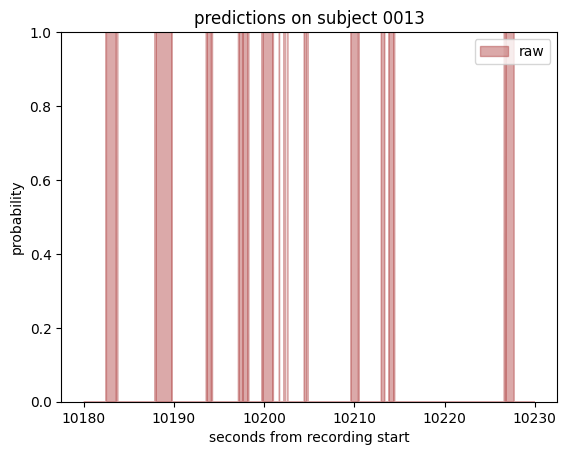

In [172]:
roi=(timepoints>roiStart)&(timepoints<roiStop)
#plt.fill(timepoints[roi],processed[roi],color='green',alpha=0.4)
plt.fill(timepoints[roi],raw[roi],color='brown',alpha=0.4)
#plt.fill(timepoints[roi],testLabels[roi],color='blue',alpha=0.4)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['raw'],loc='upper right')
plt.show()

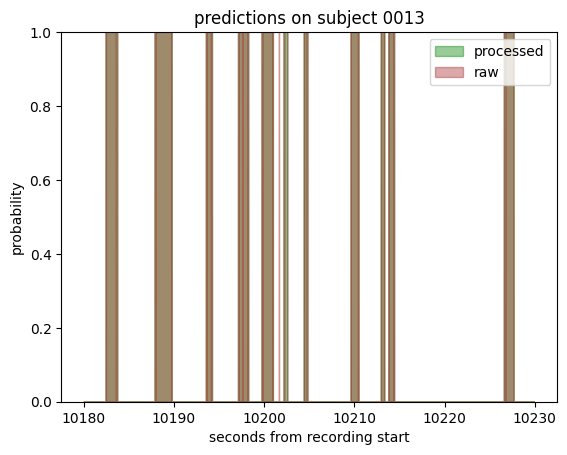

In [173]:
plt.fill(timepoints[roi],processed[roi],color='green',alpha=0.4)
plt.fill(timepoints[roi],raw[roi],color='brown',alpha=0.4)
#plt.fill(timepoints[roi],testLabels[roi],color='blue',alpha=0.4)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['processed','raw'],loc='upper right')
plt.show()

In [174]:
roiStart2=10201.5
roiStop2=10206.5
roi2=(timepoints>roiStart2)&(timepoints<roiStop2)

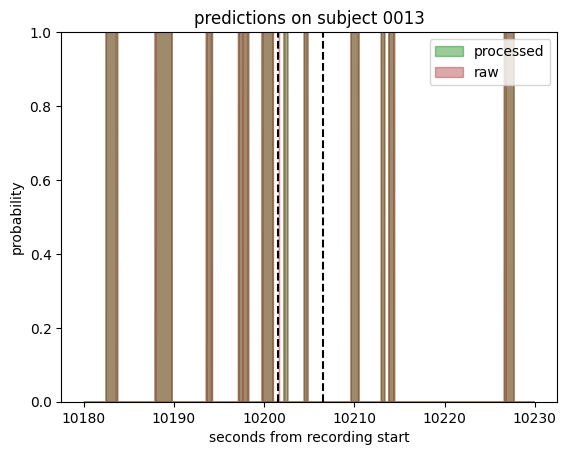

In [175]:
roi=(timepoints>roiStart)&(timepoints<roiStop)
plt.fill(timepoints[roi],processed[roi],color='green',alpha=0.4)
plt.fill(timepoints[roi],raw[roi],color='brown',alpha=0.4)
#plt.fill(timepoints[roi],testLabels[roi],color='blue',alpha=0.4)
plt.title('predictions on subject '+metadata.subjectId)
plt.vlines((roiStart2,roiStop2),ymin=0,ymax=1,color='black',linestyle='dashed')
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['processed','raw'],loc='upper right')
plt.show()

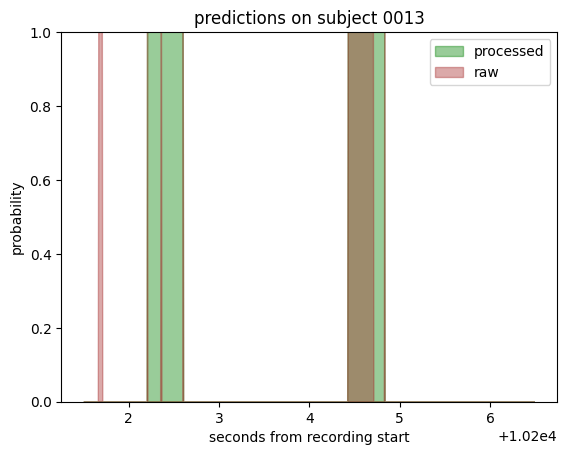

In [176]:
plt.fill(timepoints[roi2],processed[roi2],color='green',alpha=0.4)
plt.fill(timepoints[roi2],raw[roi2],color='brown',alpha=0.4)
#plt.fill(timepoints[roi],testLabels[roi],color='blue',alpha=0.4)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['processed','raw'],loc='upper right')
plt.show()

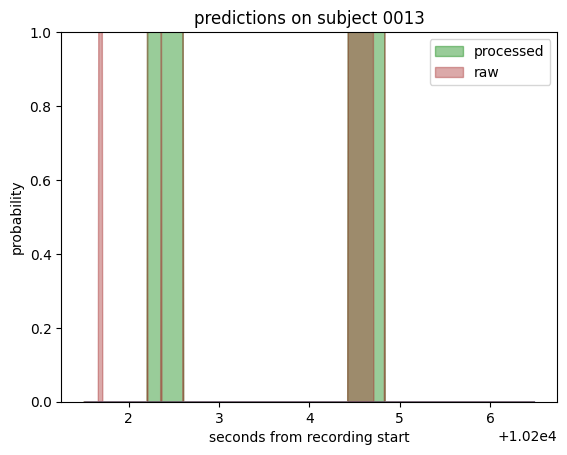

In [177]:
plt.fill(timepoints[roi2],processed[roi2],color='green',alpha=0.4)
plt.fill(timepoints[roi2],raw[roi2],color='brown',alpha=0.4)
plt.title('predictions on subject '+metadata.subjectId)
plt.ylabel('probability')
plt.xlabel('seconds from recording start')
plt.ylim((0,1))
plt.legend(['processed','raw'],loc='upper right')
plt.show()

In [178]:
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,0.5
66,petrosian,broadband,0.5
22,hjortActivity,theta,0.5
79,relativePower,beta1,0.5
29,hjortComplexity,sigma,0.5


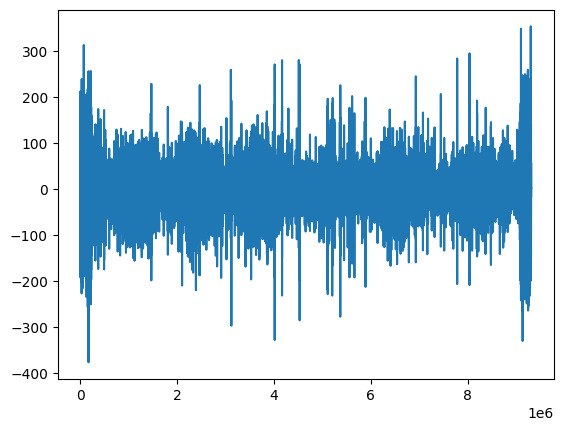

In [181]:
signal=loadPickle(datapath+'/MASS/signals/MASS_'+row.testSubjectId+'.pkl')
plt.plot(signal)

In [ ]:
plt.plot(timepoints,testLabels,color='green',alpha=0.8)
